In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import polars as pl
from numba import njit
from glob import glob
import os
import matplotlib.pyplot as plt
import datetime

In [ ]:
# Unzip part
!tar -xvf "/content/drive/MyDrive/FBD/US_flash_crash.tar" -C "/content/FBD"

流式输出内容被截断，只能显示最后 5000 行内容。
US_flash_crash/trade/UTX.N/2010-04-01-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-05-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-06-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-07-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-08-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-09-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-12-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-13-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-14-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-15-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-16-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-19-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-20-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-21-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-22-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-23-UTX.N-trade.parquet
US_flash_crash/trade/UTX.N/2010-04-26-UTX.N-t

# Flash crash date detect
This part focuses on 2010.5.6

## BBO data preparing

In [ ]:
@njit
def fast_vol_decomposition(returns):
    n = len(returns)
    if n < 2: return 0.0, 0.0
    rv = np.sum(returns**2)
    abs_ret = np.abs(returns)
    sum_prod = 0.0
    for i in range(1, n):
        sum_prod += abs_ret[i] * abs_ret[i-1]
    constant = 1.57079632679 # pi/2
    bv = constant * (n / (n - 1)) * sum_prod
    return rv, bv

def apply_vol_decomp(s: pl.Series) -> pl.Series:
    arr = s.to_numpy().astype(np.float64)
    arr = arr[~np.isnan(arr)]
    rv, bv = fast_vol_decomposition(arr)
    return pl.Series([rv, bv])

In [ ]:
def min_bbo_time(df_raw: pl.DataFrame) -> pl.DataFrame:
    # UTC converted to NY time
    df = df_raw.with_columns([
    ((pl.col("xltime") - 25569) * 86400 * 1000).cast(pl.Datetime("ms")).alias("utc_time")
]).with_columns([
    pl.col("utc_time")
    .dt.replace_time_zone("UTC")
    .dt.convert_time_zone("America/New_York")
    .dt.replace_time_zone(None)
    .alias("timestamp")])
    df = df.filter(
        pl.col("timestamp").dt.time().is_between(datetime.time(9, 30), datetime.time(16, 0))
    )# Market Hours Filtering: keep only data during standard trading hours (typically 09:30 to 16:00).

    # Calculate mid price
    df = df.filter(
        (pl.col("bid-price") > 0.01) & (pl.col("ask-price") >= pl.col("bid-price"))
    ).with_columns([
        ((pl.col("bid-price") + pl.col("ask-price")) / 2).alias("mid_price")
    ]).sort("timestamp")
    df = df.with_columns([
              pl.col("bid-volume").shift(1).alias("bid_vol_lag"),
              pl.col("ask-volume").shift(1).alias("ask_vol_lag")])
    # Calculate Deltas (First-order differences)
    # Change in Bid Price between current and previous tick
    df = df.with_columns([
        pl.col("bid-price").diff().alias("db"),
        pl.col("bid-volume").diff().alias("dv_b"),
        pl.col("ask-price").diff().alias("da"),
        pl.col("ask-volume").diff().alias("dv_a")
    ]).with_columns([
        # Calculate Inflow/Outflow
        # Bid Pressure
        pl.when(pl.col("db") > 0).then(pl.col("bid-volume"))
          .when(pl.col("db") < 0).then(-pl.col("bid_vol_lag"))
          .otherwise(pl.col("dv_b")).alias("bid_pressure"),
        # Ask Pressure (Contribution from the Ask side)
        pl.when(pl.col("da") < 0).then(pl.col("ask-volume"))
          .when(pl.col("da") > 0).then(-pl.col("ask_vol_lag"))
          .otherwise(-pl.col("dv_a")).alias("ask_pressure")
    ]).with_columns([
        # Order Flow Imbalance (OFI)
        # Aggregate the buy-side and sell-side pressures into a single signal.
        (pl.col("bid_pressure") + pl.col("ask_pressure")).alias("tick_ofi")
    ])

    df = df.with_columns([
        # Total Depth: The sum of liquidity at the best bid and best ask.
        (pl.col("bid-volume") + pl.col("ask-volume")).alias("total_depth"),
        # Tick Return: Logarithmic return of the mid-price.
        pl.col("mid_price").log().diff().fill_null(0).alias("tick_ret"),
        # Relative Spread: The bid-ask spread expressed as a fraction of the mid-price.
        ((pl.col("ask-price") - pl.col("bid-price")) / pl.col("mid_price")).alias("rel_spread")
    ]).with_columns([
        # Weighted Mid Component: Pre-calculation for Volume-Weighted Average Price (VWAP).
        (pl.col("mid_price") * pl.col("total_depth")).alias("weighted_mid")
    ])
    # Aggregation (Resampling to 1-Minute Bars)
    df_min = (
        df.group_by_dynamic("timestamp", every="1m", closed="right", label="right")
        .agg([
            (pl.col("weighted_mid").sum() / pl.col("total_depth").sum()).alias("price"),
            pl.col("tick_ofi").sum().alias("minute_ofi"),
            ((pl.col("rel_spread") * pl.col("total_depth")).sum() / pl.col("total_depth").sum()).alias("avg_spread"),
            pl.len().alias("tick_count")
        ])
    )

    return df_min

In [ ]:
BASE_PATH = "/content/FBD/US_flash_crash/bbo"
STOCKS = os.listdir(BASE_PATH)

#Pre-test: We know when flash crash happend
DATES = ["2010-04-29", "2010-04-30", "2010-05-03", "2010-05-04", "2010-05-05", "2010-05-06"]

def get_stock_minute_signals(stock_id, DATES = DATES, target_date = datetime.date(2010, 5, 6)):
    # Construct file path assuming a specific directory structure
    files = []
    for d in DATES:
        p = os.path.join(BASE_PATH, stock_id, f"{d}-{stock_id}-bbo.parquet")
        if os.path.exists(p): files.append(p)

    # Heuristic: If we have fewer than 6 days of data, we can't reliably estimate history.
    if len(files) < 6: return None

    df_raw = pl.read_parquet(files)
    df_min = min_bbo_time(df_raw)

    # History: All data strictly BEFORE the target date. Used to calibrate stats.
    df_history = df_min.filter(pl.col("timestamp").dt.date() < pl.lit(target_date))
    df_target  = df_min.filter(pl.col("timestamp").dt.date() == pl.lit(target_date))

    if df_history.height == 0 or df_target.height == 0:
        return None

    # Historical Baseline Calibration
    # Calculate key statistics from the historical period to define "Normal Market Conditions"
    stats = df_history.select([
        # Volatility of Order Flow
        pl.col("minute_ofi").median().alias("hist_ofi_mean"),
        ((pl.col("minute_ofi") - pl.col("minute_ofi").median()).abs().median()).alias("hist_ofi_mad"),
        # Typical Liquidity Cost
        pl.col("avg_spread").median().alias("hist_spread_mean"),
        ((pl.col("avg_spread") - pl.col("avg_spread").median()).abs().median()).alias("hist_spread_mad"),
    ])

    # Extract scalar values for thresholding
    ofi_std_baseline = 4*stats[0, "hist_ofi_mad"]+  stats[0, "hist_ofi_mean"]
    #spread_med_baseline = stats[0, "hist_spread_med"]
    spread_med_baseline = 4*stats[0, "hist_spread_mad"]+  stats[0, "hist_spread_mean"]

    # We flag a specific minute if TWO extreme conditions are met simultaneously:
    # 1. Extreme Order Flow Imbalance: OFI magnitude is > 3 Standard Deviations.
    # (Means massive directional buying or selling pressure).
    # 2. Liquidity Evaporation: The Spread is > 5 times the historical median.
    # (Means market makers have pulled back, cost of trading is huge).
    return df_target.select([
        "timestamp",
        pl.lit(stock_id).alias("symbol"),
        ((pl.col("minute_ofi").abs() > 1 * ofi_std_baseline) &
         (pl.col("avg_spread") > 1 * spread_med_baseline)).cast(pl.Int8).alias("signal")
    ])

In [ ]:
stock_list = [f for f in os.listdir(BASE_PATH) if os.path.isdir(os.path.join(BASE_PATH, f))]
all_results = []
for stock in stock_list:
    sig = get_stock_minute_signals(stock)
    if sig is not None: all_results.append(sig)

df_final = pl.concat(all_results).pivot(
    index="timestamp", on="symbol", values="signal"
).sort("timestamp").fill_null(0)

# Calculate the mean across the columns (axis=1).
# Meaning: For every minute, what percentage of the entire stock universe

m_signals = df_final.select(pl.exclude("timestamp")).to_numpy()
bt_series_bbo = np.mean(m_signals, axis=1)

timestamps_bbo = df_final["timestamp"].to_numpy()

## Trade data preparation

In [ ]:
def min_trade_time(df_raw: pl.DataFrame) -> pl.DataFrame:
  # Timestamp Conversion
  df = df_raw.with_columns([
        ((pl.col("xltime") - 25569) * 86400 * 1000)
        .cast(pl.Datetime("ms"))
        .dt.replace_time_zone("UTC")
        .dt.convert_time_zone("America/New_York")
        .dt.replace_time_zone(None)
        .alias("timestamp"),
        pl.col("trade-price").alias("price_val"),
        pl.col("trade-volume").alias("v_i")
    ]).sort("timestamp")

  # Filter strictly for Regular Trading Hours (RTH): 09:30:00 to 16:00:00
  df = df.filter(
        pl.col("timestamp").dt.time().is_between(datetime.time(9, 30), datetime.time(16, 0))
    )

  # Calculate Tick Returns
  df = df.with_columns([
        pl.col("price_val").log()
        .diff()
        .over(pl.col("timestamp").dt.date())
        .fill_null(0)
        .alias("tick_ret")
    ])

  # Resampling (Aggregation to 1-Minute Bars)
  df_min = (
        df.group_by_dynamic(
            "timestamp",
            every="1m",
            closed="right",
            label="right",
            start_by="window"
        )
        .agg([
            # Calculate VWAP (Volume Weighted Average Price) for this minute
            # Formula: Sum(Price * Volume) / Sum(Volume)
            ((pl.col("price_val") * pl.col("v_i")).sum() / pl.col("v_i").sum()).alias("price"),
            # Total Volume traded in this minute
            pl.col("v_i").sum().alias("minute_volume"),
            # Apply Custom Volatility Metrics
            pl.col("tick_ret").map_batches(apply_vol_decomp).alias("vol_metrics"),
            pl.len().alias("trade_count")
        ])
    )

  # The 'vol_metrics' column contains a list (e.g., [RV, BV]).
  # Unpack it into separate columns for usability.
  df_min = df_min.with_columns([
        pl.col("vol_metrics").list.get(0).alias("rv"),
        pl.col("vol_metrics").list.get(1).alias("bv")
    ]).drop("vol_metrics")

  return df_min

In [ ]:
TRADE_BASE_PATH= "/content/FBD/US_flash_crash/trade"

def get_trade_market_signals(stock_id, DATES=DATES, target_date=pl.date(2010, 5, 6)):
    # Construct expected file paths for all dates in the range.
    files = [os.path.join(TRADE_BASE_PATH, stock_id, f"{d}-{stock_id}-trade.parquet") for d in DATES]
    valid_files = [f for f in files if os.path.exists(f)]
    # Heuristic: Require at least 6 days of data to establish a reliable baseline.
    if len(valid_files) < 6: return None

    dfs = []
    # Data Loading & Type Casting( to avoid inconsistent data formats)
    for f in valid_files:
        # Load parquet and cast volume/price to Float64 immediately
        # to prevent overflow or type mismatch errors during aggregation.
        d = pl.read_parquet(f).with_columns([
            pl.col("trade-volume").cast(pl.Float64),
            pl.col("trade-price").cast(pl.Float64)
        ])
        dfs.append(d)

    df_raw = pl.concat(dfs, how="vertical_relaxed")
    df_min = min_trade_time(df_raw)

    # Feature Engineering for Jump Detection
    df_min = df_min.with_columns([
        pl.col("timestamp").dt.date().alias("date")
    ]).with_columns([
        # Calculate Minute-by-Minute Log Returns.
        # .over("date") ensures we calculate returns within the trading day only,
        # avoiding large overnight jumps (Close T-1 to Open T) influencing the stats.
        pl.col("price").log()
        .diff()
        .over("date")
        .fill_null(0)# First minute of the day has no return, set to 0
        .alias("log_ret")
    ])

    # History: Data strictly before the target date used for calibration.
    df_history = df_min.filter(pl.col("date") < target_date)
    # Target: The specific day we are analyzing for anomalies.
    df_target = df_min.filter(pl.col("date") == target_date)

    # Safety check: ensure both periods have data.
    if df_history.height == 0 or df_target.height == 0:
        return None
    # Lee-Mykland Statistic
    # Calculate the historical mean of Bipower Variation (BV).
    # BV is a robust estimator of integrated variance that is insensitive to jumps.

    hist_bv_mu = df_history.select(pl.col("bv").mean()).item()
    # Avoid division by zero or negative variance in edge cases.
    if hist_bv_mu <= 0: hist_bv_mu = 1e-9
    # Calculate the LM Statistic (proxy):
    # Stat = |Return_t| / sqrt(Historical_Robust_Variance)
    # This standardizes the current minute's return by the typical historical volatility.
    # A high value indicates a move that is "too big" relative to normal variance (a Jump).
    res = df_target.with_columns([
        (pl.col("log_ret").abs() / (hist_bv_mu**0.5)).alias("LM_stat")
    ]).fill_null(0)
    # Identify the listing exchange based on the suffix (Market Microstructure convention).
    market_name = "Nasdaq" if stock_id.endswith(".OQ") else "NYSE"
    return res.select([
        "timestamp",
        pl.lit(stock_id).alias("symbol"),
        pl.lit(market_name).alias("market"),
        (pl.col("LM_stat") > 5.0).cast(pl.Int8).alias("signal_trade")
    ])

In [ ]:
trade_stock_list = [f for f in os.listdir(TRADE_BASE_PATH) if os.path.isdir(os.path.join(TRADE_BASE_PATH, f))]

all_trade_results = []
for stock in trade_stock_list:
    sig = get_trade_market_signals(stock)
    if sig is not None and sig.height > 0:
        all_trade_results.append(sig)

df_final_trade = pl.concat(all_trade_results).pivot(
    index="timestamp", on="symbol", values="signal_trade"
).sort("timestamp").fill_null(0)
timestamps_trade = df_final_trade.select("timestamp").to_numpy().flatten()
m_trade = df_final_trade.select(pl.exclude("timestamp", "market")).to_numpy()
bt_trade_series = np.mean(m_trade, axis=1)

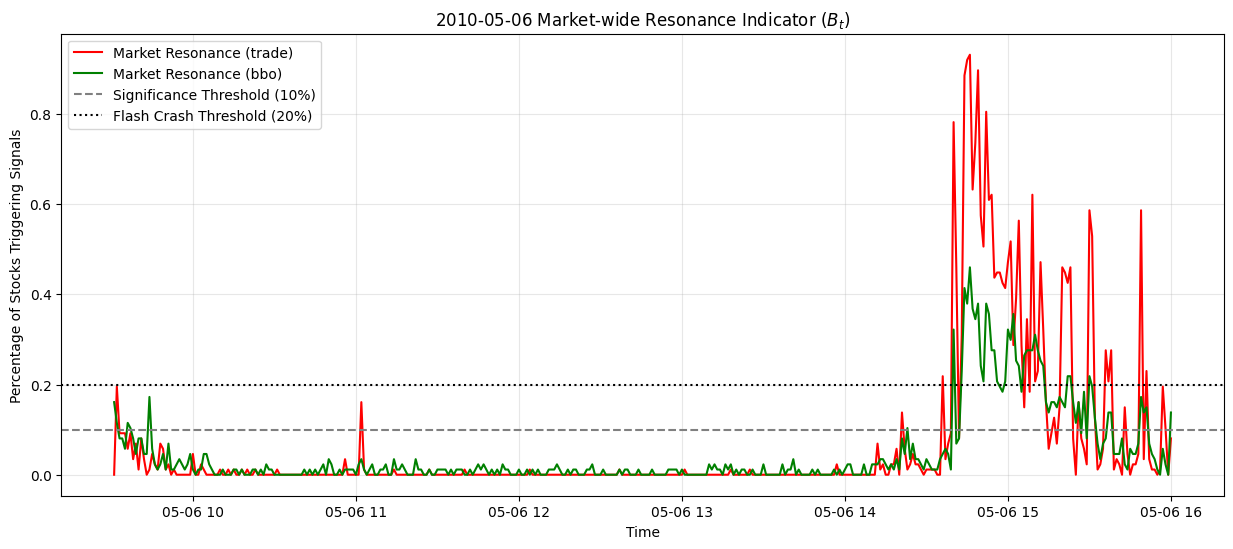

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(timestamps_trade, bt_trade_series, label="Market Resonance (trade)", color='red', linewidth=1.5)
plt.plot(timestamps_bbo, bt_series_bbo, label="Market Resonance (bbo)", color='green', linewidth=1.5)
plt.axhline(y=0.10, color='gray', linestyle='--', label="Significance Threshold (10%)")
plt.axhline(y=0.20, color='black', linestyle=':', label="Flash Crash Threshold (20%)")

plt.title("2010-05-06 Market-wide Resonance Indicator ($B_t$)")
plt.ylabel("Percentage of Stocks Triggering Signals")
plt.xlabel("Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
#Synchronize and Merge Signals
# We now have two separate time-series arrays from previous steps:
# 1. Trade-based Breadth (bt_trade_series): Measures volatility/jumps based on executed trades.
# 2. BBO-based Breadth (bt_series_bbo): Measures liquidity/order flow shocks based on the order book.
df_sync = pl.DataFrame({
    "timestamp": timestamps_trade,
    "bt_trade": bt_trade_series
}).join(
    pl.DataFrame({
        # Join Key: Match rows based on the exact minute ('timestamp').
        "timestamp": timestamps_bbo,
        "bt_bbo": bt_series_bbo
    }),
    # Join Type: 'inner'
    # This acts as a strict filter. We only keep minutes where we have VALID data
    # from BOTH sources. If one dataset is missing a minute (e.g., due to different
    # filtering or missing files), that minute is dropped.
    # This ensures that any correlation or combined signal we calculate later is statistically valid.
    on="timestamp",
    how="inner"
).sort("timestamp")

# Global detectaion via 5 last trading dates history
Now assume we do not know the flash crash date, we use 5 last trading dates as rolling window to get rolling historical data

In [ ]:
import re

In [ ]:
def get_all_trading_dates(base_path):
    # Recursively find all .parquet files in the given directory and subdirectories
    all_files = glob(os.path.join(base_path, "**", "*.parquet"), recursive=True)
    # Use a set to store dates to ensure uniqueness (deduplication)
    dates = set()
    date_pattern = re.compile(r"(\d{4}-\d{2}-\d{2})")
    for f in all_files:
        filename = os.path.basename(f)
        match = date_pattern.search(filename)
        # If a valid date is found, add it to the set
        if match:
            dates.add(match.group(1))
    return sorted(list(dates))


print("Scanning files for trading dates...")
bbo_dates = get_all_trading_dates(BASE_PATH)
trade_dates = get_all_trading_dates(TRADE_BASE_PATH)

ALL_DATES = sorted(list(set(bbo_dates).intersection(set(trade_dates))))

print(f"Total valid trading dates found: {len(ALL_DATES)}")
print(f"Date range: {ALL_DATES[0]} to {ALL_DATES[-1]}")

Scanning files for trading dates...
Total valid trading dates found: 252
Date range: 2010-01-04 to 2010-12-31


In [ ]:
def run_global_rolling_detection(stock_list, trade_stock_list, all_dates, window_size=5, threshold=0.20):

    potential_crashes = []
    # Iterate through the dates, starting from the index equal to window_size.
    # We need at least 'window_size' prior days to establish a history baseline.
    for i in range(window_size, len(all_dates)):
        target_date_str = all_dates[i]
        # Define the Rolling Window:
        # 1. history_dates: The previous 'window_size' days used for statistical calibration (e.g., mean/std).
        # 2. current_batch_dates: The history + the target date, passed to data loaders to ensure context.
        history_dates = all_dates[i-window_size : i]
        current_batch_dates = history_dates + [target_date_str]
        # Convert string date to a python date object for Polars compatibility
        target_date_obj = datetime.datetime.strptime(target_date_str, "%Y-%m-%d").date()

        print(f"\nProcessing Target: {target_date_str} (History: {history_dates[0]} to {history_dates[-1]})")
        # Detect liquidity stress: high order flow imbalance + widened spreads.
        bbo_signals = []
        for stock in stock_list:
            # Calculate signals for individual stock using the defined batch of dates
            try:
                sig = get_stock_minute_signals(stock, DATES=current_batch_dates, target_date=target_date_obj)
                if sig is not None:
                    bbo_signals.append(sig)
            except Exception as e:
                # Gracefully handle missing data or errors for specific stocks
                continue

        if not bbo_signals:
            print(f"  [Skip] No BBO signals for {target_date_str}")
            continue

        # Aggregate BBO signals:
        # Concatenate all stock signals and pivot to a wide format (Time x Stock).
        # Fill missing values with 0 (assuming no signal if no data).
        df_bbo = pl.concat(bbo_signals).pivot(
            index="timestamp", on="symbol", values="signal"
        ).fill_null(0).sort("timestamp")

        bbo_vals = df_bbo.select(pl.exclude("timestamp")).to_numpy()
        bt_bbo = np.mean(bbo_vals, axis=1)

        # Detect volatility jumps: price moves exceeding historical volatility (Lee-Mykland stat).
        trade_signals = []
        for stock in trade_stock_list:
            try:

                sig = get_trade_market_signals(stock, DATES=current_batch_dates, target_date=target_date_obj)
                if sig is not None:
                    trade_signals.append(sig)
            except Exception as e:
                continue

        if not trade_signals:
            print(f"  [Skip] No Trade signals for {target_date_str}")
            continue
        # Aggregate Trade signals:
        # Pivot to wide format (Time x Stock) to align timestamps across the market.
        df_trade = pl.concat(trade_signals).pivot(
            index="timestamp", on="symbol", values="signal_trade"
        ).fill_null(0).sort("timestamp")
        # Calculate Market Breadth for Trade (Bt_Trade):
        # The mean across the row gives the percentage of stocks triggering a volatility jump alarm.
        trade_vals = df_trade.select(pl.exclude("timestamp", "market")).to_numpy()
        bt_trade = np.mean(trade_vals, axis=1)

        # Signal Intersection & Detection
        df_res_bbo = pl.DataFrame({"timestamp": df_bbo["timestamp"], "bt_bbo": bt_bbo})
        df_res_trade = pl.DataFrame({"timestamp": df_trade["timestamp"], "bt_trade": bt_trade})

        # Inner Join: Only keep timestamps where we have valid data from BOTH sources.
        # This synchronizes the Liquidity and Volatility signals.
        df_merged = df_res_bbo.join(df_res_trade, on="timestamp", how="inner")

        # Flash Crash Condition:
        # A crash is identified if BOTH the BBO liquidity stress AND Trade volatility jumps
        # exceed the defined threshold (e.g., >10% of the market) simultaneously.
        crash_ticks = df_merged.filter(
            (pl.col("bt_bbo") > threshold) &
            (pl.col("bt_trade") > threshold)
        )

        if crash_ticks.height > 0:
            print(f"  >>> ALERT: Potential Flash Crash Detected on {target_date_str} <<<")
            for row in crash_ticks.iter_rows(named=True):
                print(f"      Time: {row['timestamp'].time()} | Liquidity Stress: {row['bt_bbo']:.2%} | Trade Jumps: {row['bt_trade']:.2%}")

                potential_crashes.append({
                    "date": target_date_str,
                    "timestamp": row['timestamp'],
                    "bt_bbo": row['bt_bbo'],
                    "bt_trade": row['bt_trade']
                })
        else:
            print(f"  [OK] No system-wide crash detected.")

    return potential_crashes

The full year test takes approximately three hours, so it has been commented out. You can uncomment it if you wish to reproduce the results.

In [ ]:
# crashes = run_global_rolling_detection(
#     stock_list=stock_list,
#     trade_stock_list=trade_stock_list,
#     all_dates=ALL_DATES,
#     window_size=5,
#     threshold=0.30
# )

# print("\n" + "="*50)
# print("FINAL FLASH CRASH REPORT")
# print("="*50)
# if crashes:
#     for c in crashes:
#         print(f"Date: {c['date']} | Time: {c['timestamp'].time()} | BBO_Stress: {c['bt_bbo']:.2f} | Trade_Jump: {c['bt_trade']:.2f}")
# else:
#     print("No flash crash events detected in the processed dates.")


Processing Target: 2010-01-11 (History: 2010-01-04 to 2010-01-08)
  [OK] No system-wide crash detected.

Processing Target: 2010-01-12 (History: 2010-01-05 to 2010-01-11)
  [OK] No system-wide crash detected.

Processing Target: 2010-01-13 (History: 2010-01-06 to 2010-01-12)
  [OK] No system-wide crash detected.

Processing Target: 2010-01-14 (History: 2010-01-07 to 2010-01-13)
  [OK] No system-wide crash detected.

Processing Target: 2010-01-15 (History: 2010-01-08 to 2010-01-14)
  [OK] No system-wide crash detected.

Processing Target: 2010-01-19 (History: 2010-01-11 to 2010-01-15)
  [OK] No system-wide crash detected.

Processing Target: 2010-01-20 (History: 2010-01-12 to 2010-01-19)
  [OK] No system-wide crash detected.

Processing Target: 2010-01-21 (History: 2010-01-13 to 2010-01-20)
  [OK] No system-wide crash detected.

Processing Target: 2010-01-22 (History: 2010-01-14 to 2010-01-21)
  [OK] No system-wide crash detected.

Processing Target: 2010-01-25 (History: 2010-01-15 to 